---
title: "Exploratory Data Analysis"
format:
    html: 
        code-fold: false
---

<br>
<br>

# Overview

Now that I have finally loaded in and cleaned the data, it's time for the fun part. In this section, I dive into the the Amazon Electronics reviews dataset. My objectives are as follows:

 - Uncover any potential issues in the data set
 - Summarize key characteristics of the data
 - Identify any patterns or anomalies
 - Prepare for the upcoming modeling stages

As another point - from here on, I will work only with the smaller version of the data due to memory and compute bottlenecks on my local device. That dataset retains all of the cleaned variables with only 100,000 rows rather than our initial 6.7 million rows. My hope is that this sample size is large enough to capture all trends that exist in the population data set, while offering also being lightweight enough for multiple model iterations


# Code 

## Importing Libraries

In this section, I import all of the packages necessary for generating different types of visualizations for the data. In addition to visualization-related packages, I also bring in pandas & numpy for easy data manipulation and nltk for ngrams analysis. Finally, I will import various specialized packags for robust textual data EDA and dimension reduction.

In [2]:
# Standard Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Text-based processing and analysis packages
from sklearn.feature_extraction.text import CountVectorizer

# Dimension reduction packages
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')


## Loading in data

Now, let's begin by loading in the cleaned data set that I constructed in the previous section:


In [3]:
import gzip

# Pathway to raw data
data_path = "../../data/processed-data/reviews_short.csv.gz"

# Unzip the CSV file
with gzip.open(data_path, 'rb') as f:
    # Read the CSV file into a dataframe
    reviews = pd.read_csv(f)

In [4]:
# first few lines
reviews.head()

,reviewRating,vote,verified,reviewTime,reviewerID,productID,reviewerName,reviewText,summary,reviewTextClean,summaryClean,binary_target
0,5.0,2,False,2016-06-17,A7HY1CEDK0204,B00I9GYG8O,Jor El,If you're looking for Cinema 4K capabilities o...,Filmmakers will love this camera.,youre looking cinema k capabilities budget cam...,filmmakers love camera,positive
1,2.0,0,False,2018-07-13,A16KA1REUFF1R8,B01DB6BK5I,Jason A. Dangelo,"<div id=""video-block-R14IHTRCCNUS1P"" class=""a-...",Web-cams from 2002 packed in a non-discrete bu...,div idvideoblockrihtrccnusp classasection aspa...,webcams packed nondiscrete buggy package,negative
2,5.0,0,True,2018-02-05,A3TUCX8PIDH0JA,B00011KM3I,Alcerio,Great products and excellent services!,Five Stars,great products excellent services,five stars,positive
3,5.0,0,True,2014-01-16,A255B39EEYELQ8,B000EDOSFQ,herbert nichols,"Priced rivaled any one sided dvd case, easy to...",Satisfied,priced rivaled one sided dvd case easy open dv...,satisfied,positive
4,1.0,5,True,2017-08-07,A5HL1JPPIMUM3,B01CVOLKKQ,G. E. Roquet,"Only made it a year, then burned up. Had to cy...",Melted,made year burned cycle almost every day last m...,melted,negative


## Basic Summary Statistics
- Summary of quantitative columns `reviewRating` and `vote`
- mean review length (words)
- frequency of different ratings score and binary sentiments
- distribution of community vote numbers (excluding 0)

### Looking at `reviewRating` and number of community votes (`vote`)

First, lets look at a summary of our two main numerical columns `reviewRating` and `vote`. When cleaning the data initially, I noticed that there are a lot of reviews that have no community votes. To address that, I will create a temporary data set called `reviews_votes` that drops all rows where no votes are placed. Then, we can use the pandas `.describe()` function, to print out the following summary statistics for each column:

- `count` (Number of observations)
- `mean` (Average value)
- `std` (Standard Deviation)
- `min` (Minimum value)
- `25th` (25th percentile value)
- `50th` (Median value)
- `75th` (75th percentile value)
- `max` (Maximum value)

In [5]:
# Temporary data set that ignores zero vote reviews
review_votes = reviews[reviews['vote'] != 0]
summary_stats = review_votes[['reviewRating', 'vote']].describe()

# Printing Summary stats
print("SUMMARY STATS FOR QUANTITATIVE COLUMNS:")
print("========================================")
summary_stats

SUMMARY STATS FOR QUANTITATIVE COLUMNS:


,reviewRating,vote
count,13977.000000,13977.000000
mean,3.875152,11.799099
std,1.451692,84.030018
min,1.000000,2.000000
25%,3.000000,2.000000
50%,5.000000,4.000000
75%,5.000000,7.000000
max,5.000000,6770.000000


<br>

**Interpretation**

Due to the discrete, ordinal structure of the `reviewRating` column, there is not much dispersion between the median, 75th percentile, and maximum values. However, the column mean of 3.87 and median of 5 suggests that the distribution of reviewRatings is left-skewed, with over 50% of reviews containing 5-star ratings. This result echoes back to the concerns raised in the paper written by Magdelano et al. in which the researchers faced an overpresence of highly positive review ratings in their analysis of bakery reviews[@Magdelano2024]. For a better understanding of how they tackled that issue, you can refer to their work (cited below), or to my literature review of the paper on the [home](../../index.qmd) page.

Let us now shift our focus now to the summary statistics of the `vote` column. When looking at these results, one thing become abundantly clear - there is extreme variation and skewness in the distribution of community votes cast toward different reviews. For non-zero vote entries, the mean number of community votes is around 11.8 per post, with a standard deviation of 84 votes and maximum value of 6770 votes. To further quantify these characteristics, I will calculate the skewness and kurtosis of vote counts. In case you are unfamiliar with these values, "skewness" classifies the amount of assymmetry in a distribution (whether one tail is longer than the other), while kurtosis measures the "tailedness" of a distribution or what the ends of either side of the distribution look like[@SkewKurt].

***Here is a diagram to help***

![](../../xtra/multiclass-portfolio-website/images/skewness_and_kurtosis.png){width="400px"} 

[Source: Research Gate](https://www.researchgate.net/publication/316114940/figure/fig1/AS:961444636012553@1606237672944/The-illustration-of-skewness-and-kurtosis-in-a-distribution.gif)

Now let's find the actual numerical values:

In [6]:
from scipy.stats import skew, kurtosis

print(f"Skewness of Vote Counts: {skew(review_votes['vote'])}")
print(f"Kurtosis of Vote Counts: {kurtosis(review_votes['vote'])}")

Skewness of Vote Counts: 58.06515030184553
Kurtosis of Vote Counts: 4208.537902609067


**Skewness:** Our value for skewness of around 58 indicates that the distribution of vote counts is extremely positively skewed - meaning vote counts for reviews are concentrated primarily around lower values. For context, a normal distribution typically has a skewness around 0.

**Kurtosis:** The kurtosis value of around 4208 tells us that the distribution of vote counts has very heavy tails. In other words, there are an extreme number of outliers present in our collection of community votes. For context, the standard normal distribution has a kurtosis of only 3.

### Plotting Distribution of Raw vs Clean Review Text Lengths

Let's move on now to looking at the distributions of the `reviewText` and `reviewTextClean` columns. The goal for this section is to gain some initial intuition into whether our text processing in the data cleaning section actually worked as intended. In order to do this, I will count the number of words and number of characters in each column and place them into two different plots showing the overlapping distributions of characters counts and word counts between the raw and cleaned text.

In [7]:
#| echo: false
reviews['reviewTextClean'] = reviews['reviewTextClean'].astype(str)

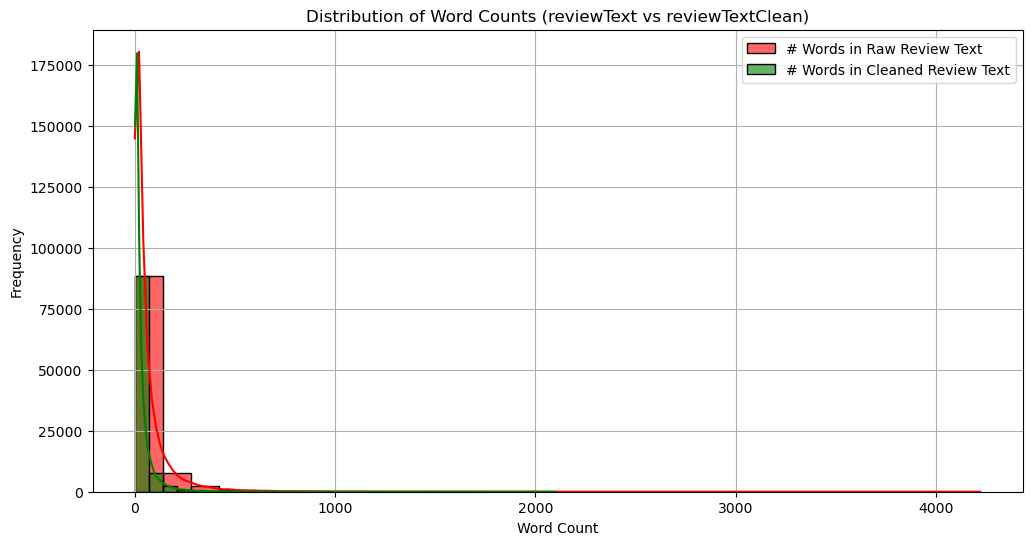

In [8]:
# Plotting distributions of word counts:
plt.figure(figsize=(12,6))
sns.histplot(reviews['reviewText'].apply(lambda x: len(x.split())), kde=True, bins=30, label="# Words in Raw Review Text", color="red", alpha=0.6)
sns.histplot(reviews['reviewTextClean'].apply(lambda x: len(x.split())), kde=True, bins=30, label='# Words in Cleaned Review Text', color='green', alpha=0.6)
plt.title('Distribution of Word Counts (reviewText vs reviewTextClean)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

**Interpretation** 
At a glance, it appears that our text processing step works as intended. In the above plot, we observe a left-ward shift in the distribution of word-length for the clean text after removing stopwords from the data. Now, lets create a similar plot showing the character counts:

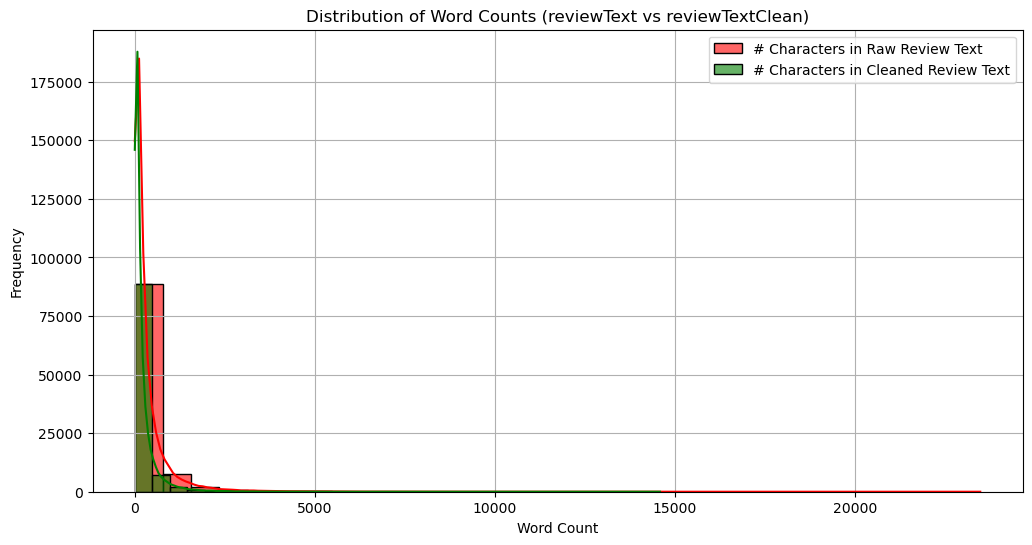

In [9]:
# Plotting distributions of character counts:
plt.figure(figsize=(12,6))
sns.histplot(reviews['reviewText'].apply(len), kde=True, bins=30, label='# Characters in Raw Review Text', color='red', alpha=0.6)
sns.histplot(reviews['reviewTextClean'].apply(len), kde=True, bins=30, label='# Characters in Cleaned Review Text', color='green', alpha=0.6)
plt.title('Distribution of Word Counts (reviewText vs reviewTextClean)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

As expected, we observe the same leftward shift in the distribution of character counts for the cleaned text

## Frequently Appearing Terms by Review Rating

### Document Term Matrix 

Moving forward, let's now take a look at how different keywords relate to review ratings given in the dataset. For this section, I will leverage the `CountVectorizer` object from `sklearn`. In case you are unfamiliar, the `CountVectorizer` object takes in our reviews data, and converts it into a document frequency matrix where each row will represent a review, and each column represents a different word found in our every review. Each element of the matrix corresponds to the number of times word $i$ appears in document $j$. One of the greatest benefits to using `CountVectorizer` is its ability to convert unstructured text data into a meaningful numeric format. In the case below, I focus on the top 10 most common keywords for each of the five different star rating assigned to amazon electronics products.

**Example of a DTM:**
<br>
![](../../xtra/multiclass-portfolio-website/images/DTM.jpg){width="400px"} 

[Source: Stack Overflow](https://stackoverflow.com/questions/38712750/how-could-i-make-document-term-matrix-with-my-own-term-list)
<br>


From there, I will create 5 separate plots for each review score that contain bar graphs of the most frequently appearing terms. The goal for this process is to gain a better understanding of which words are more likely to appear for different product ratings.

For creating the plots themselves, I use the `plot_top_words()` function defined in [dsan5000_hw-1.ipynb](https://drive.google.com/file/d/1hAT8fF0UuDyjLUyuisCngYP4VIA-evZH/view?usp=sharing). However, when implementing this function, a few necessary changes had to be made. In the original function (cited above), the required inputs are a non-negative matrix factorization model, a list of words extracted from a document term matrix, and the `n_top_words` parameter. In my implementation, I elect to use only two inputs - a pandas dataframe, and the `top_n_words` parameter. The updated function then creates a document term matrix, and extracts the word list and frequencies natively using the inputed pandas dataframe. From there, the process is essentially the same - where both functions continue on by sorting the top n words, and plotting them based on the target labels. Within the function below, I leverage a popular LLM in two cases - both having to do with the overall format of the end plots. In the first case, I use OpenAI's GPT-4o model to assist in setting up a grid structure for my subplots in order to give them a cleaner presenation on this website[@GridVisualization]. In the second case, I look for help on removing the final blank plot in the visualization[@SubplotRemoval].

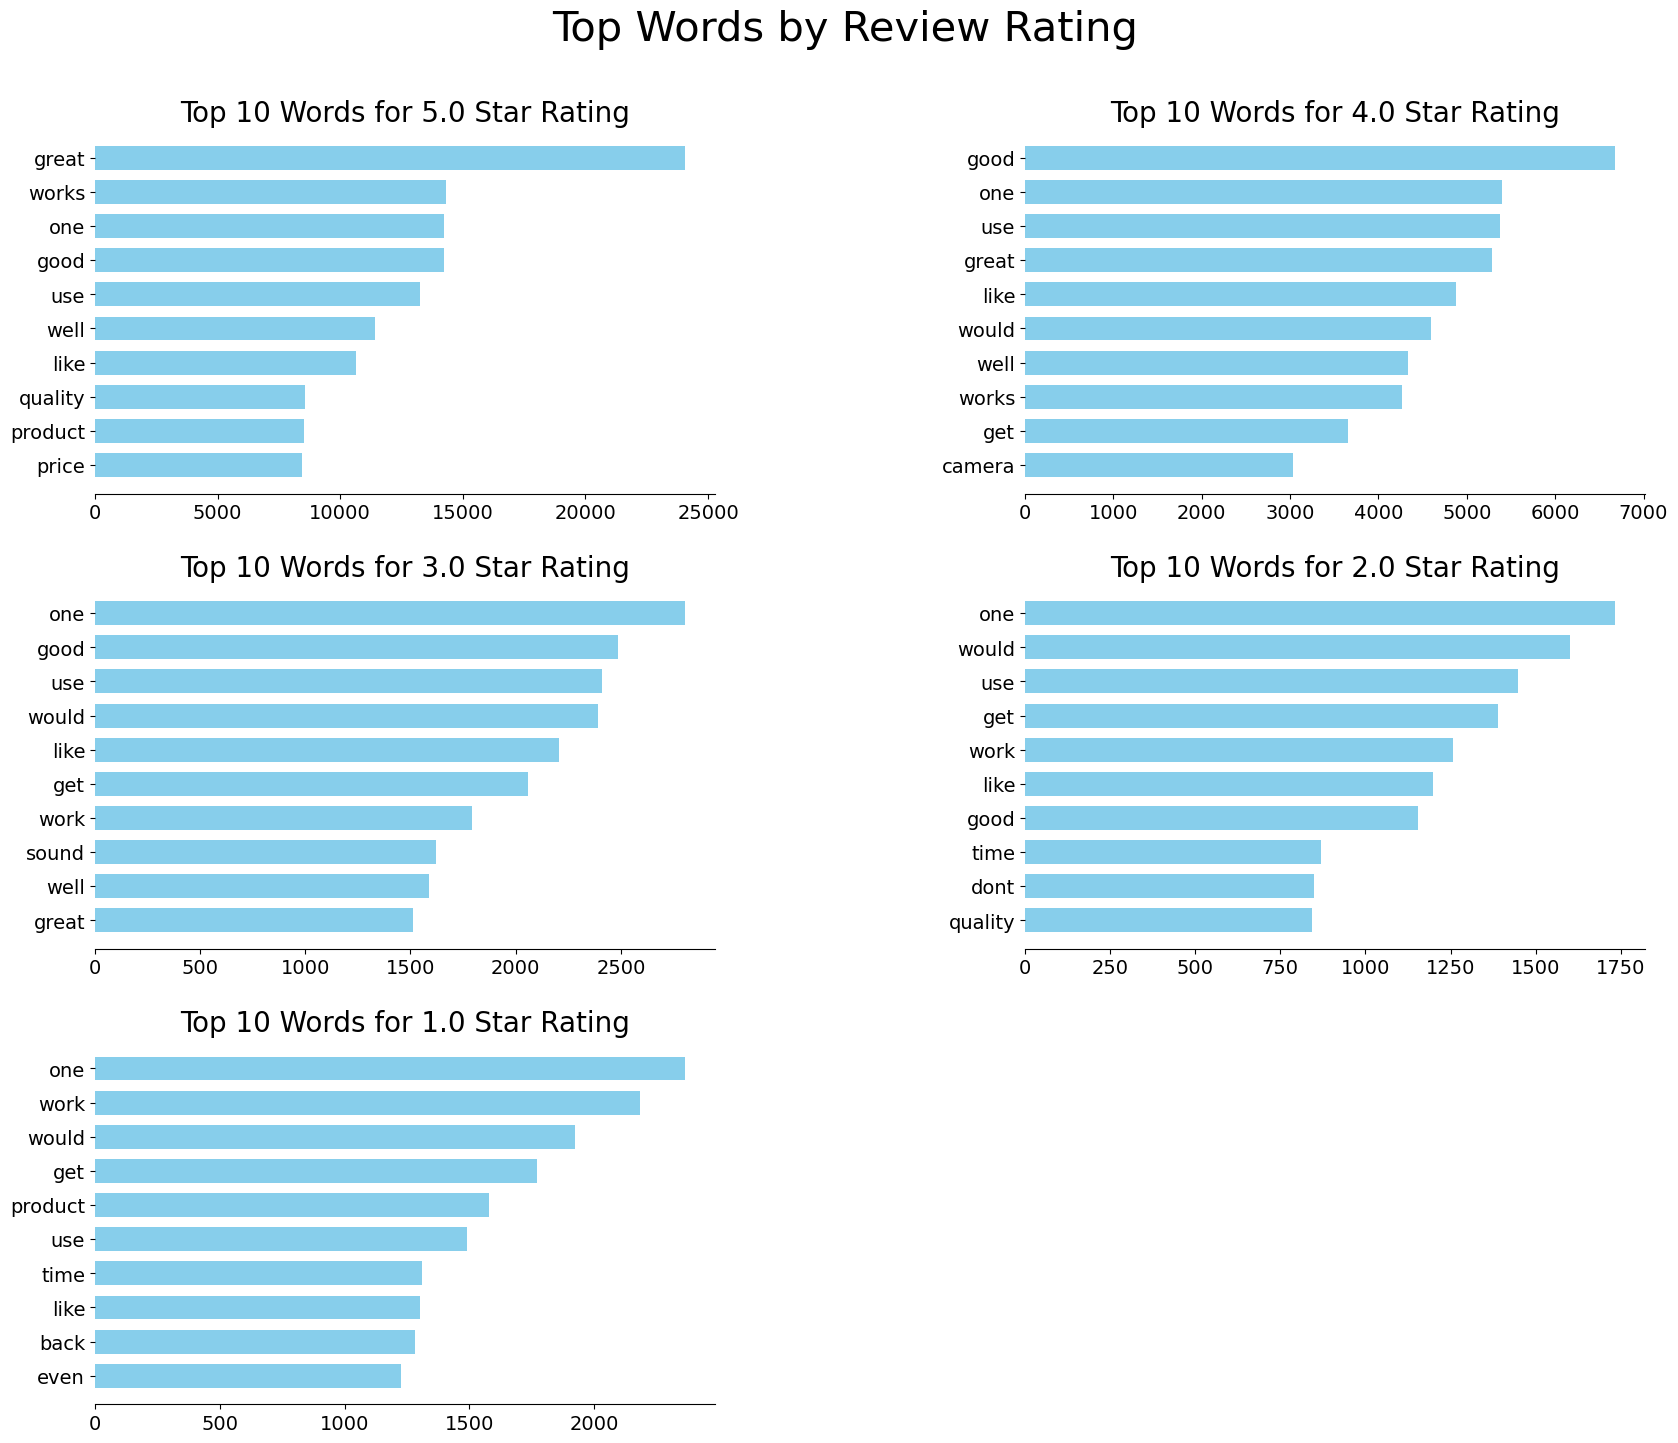

In [10]:
def plot_top_words_by_rating(reviews, n_top_words=10):
    """
    This function will plot the "n_top_words" based on user rating
    """
    # Initialize the CountVectorizer
    vectorizer = CountVectorizer(max_features=n_top_words)

    # Getting unique values for user review ratings 
    ratings = sorted(reviews['reviewRating'].unique(), reverse=True)
    
    ######### See [4] in references
    # Determine grid size (2x2, 3x3, etc.)
    n_rows = int(np.ceil(len(ratings) / 2))  # 2 columns per row
    n_cols = 2
    #########

    # Initialize figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()  

    # Loop through review ratings
    for idx, rating in enumerate(ratings):
        # Only look at reviews that have the current rating we are looping for
        filtered_reviews = reviews[reviews['reviewRating'] == rating]['reviewTextClean']

        # Fitting and transforming the reviews
        X = vectorizer.fit_transform(filtered_reviews)
        terms = vectorizer.get_feature_names_out() # This function extracts the actual term names from the fequency matrix
        frequencies = X.sum(axis=0).A1 # Here, we are taking the column sums (word totals) across all of the data

        # Sorting terms by frequency
        top_features_ind = frequencies.argsort()[-n_top_words:] 
        top_features = terms[top_features_ind]  
        weights = frequencies[top_features_ind]  

        # Ploting top n words
        ax = axes[idx]
        ax.barh(top_features, weights, height=0.7, color="skyblue") 
        ax.set_title(f"Top {n_top_words} Words for {rating} Star Rating", fontdict={"fontsize": 20})
        ax.tick_params(axis="both", which="major", labelsize=14)
        for i in "top right left".split():  
            ax.spines[i].set_visible(False)


    ######## See [5] in references
    # Hide any unused subplots
    for i in range(len(ratings), len(axes)):
        fig.delaxes(axes[i])
    ########

    fig.suptitle("Top Words by Review Rating", fontsize=30)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.5, hspace=0.25)
    plt.show()


plot_top_words_by_rating(reviews, n_top_words=10)

Unfortunately, these results are pretty unclear. There are multiple cases where the top words do not have any real relevance to their related review score. For example, in almost every plot, the top term is `one`... It is impossible to know what the context of this is. Similarly, we can see a high prevalence of the word "would" in many of the plots. However, there is a hint to what is going on in these plots. If you refer to the plots for 1- 2- and 3-star reviews, you can see that the word "work" appears in all three. Somewhat counterintuitive, no? It doesn't seem very likely that the word "work" should have any association with low-rated electronics. That is exactly where the problem lies. In reality, it's highly possible that the word "work" in most of these negative reviews follows the word "dont" (in the case of the cleaned text). Therefore, the next step in my analysis will be re-running these visualizations. However, this time, I will look at the most frequent "bigrams" or pairs of words. By doing this, I should be able to account for cases of negation in the review text.

In `plot_top_bigrams_by_rating()` below, I repeat all of the steps taken in `plot_top_words_by_rating()`, with the edition of the `ngram_range=(2,2)` parameter, which I source from an [article](https://stackoverflow.com/questions/51158638/countvectorize-vocabulary-specification-for-bigrams-python) on stack overflow. Let's see how it goes:

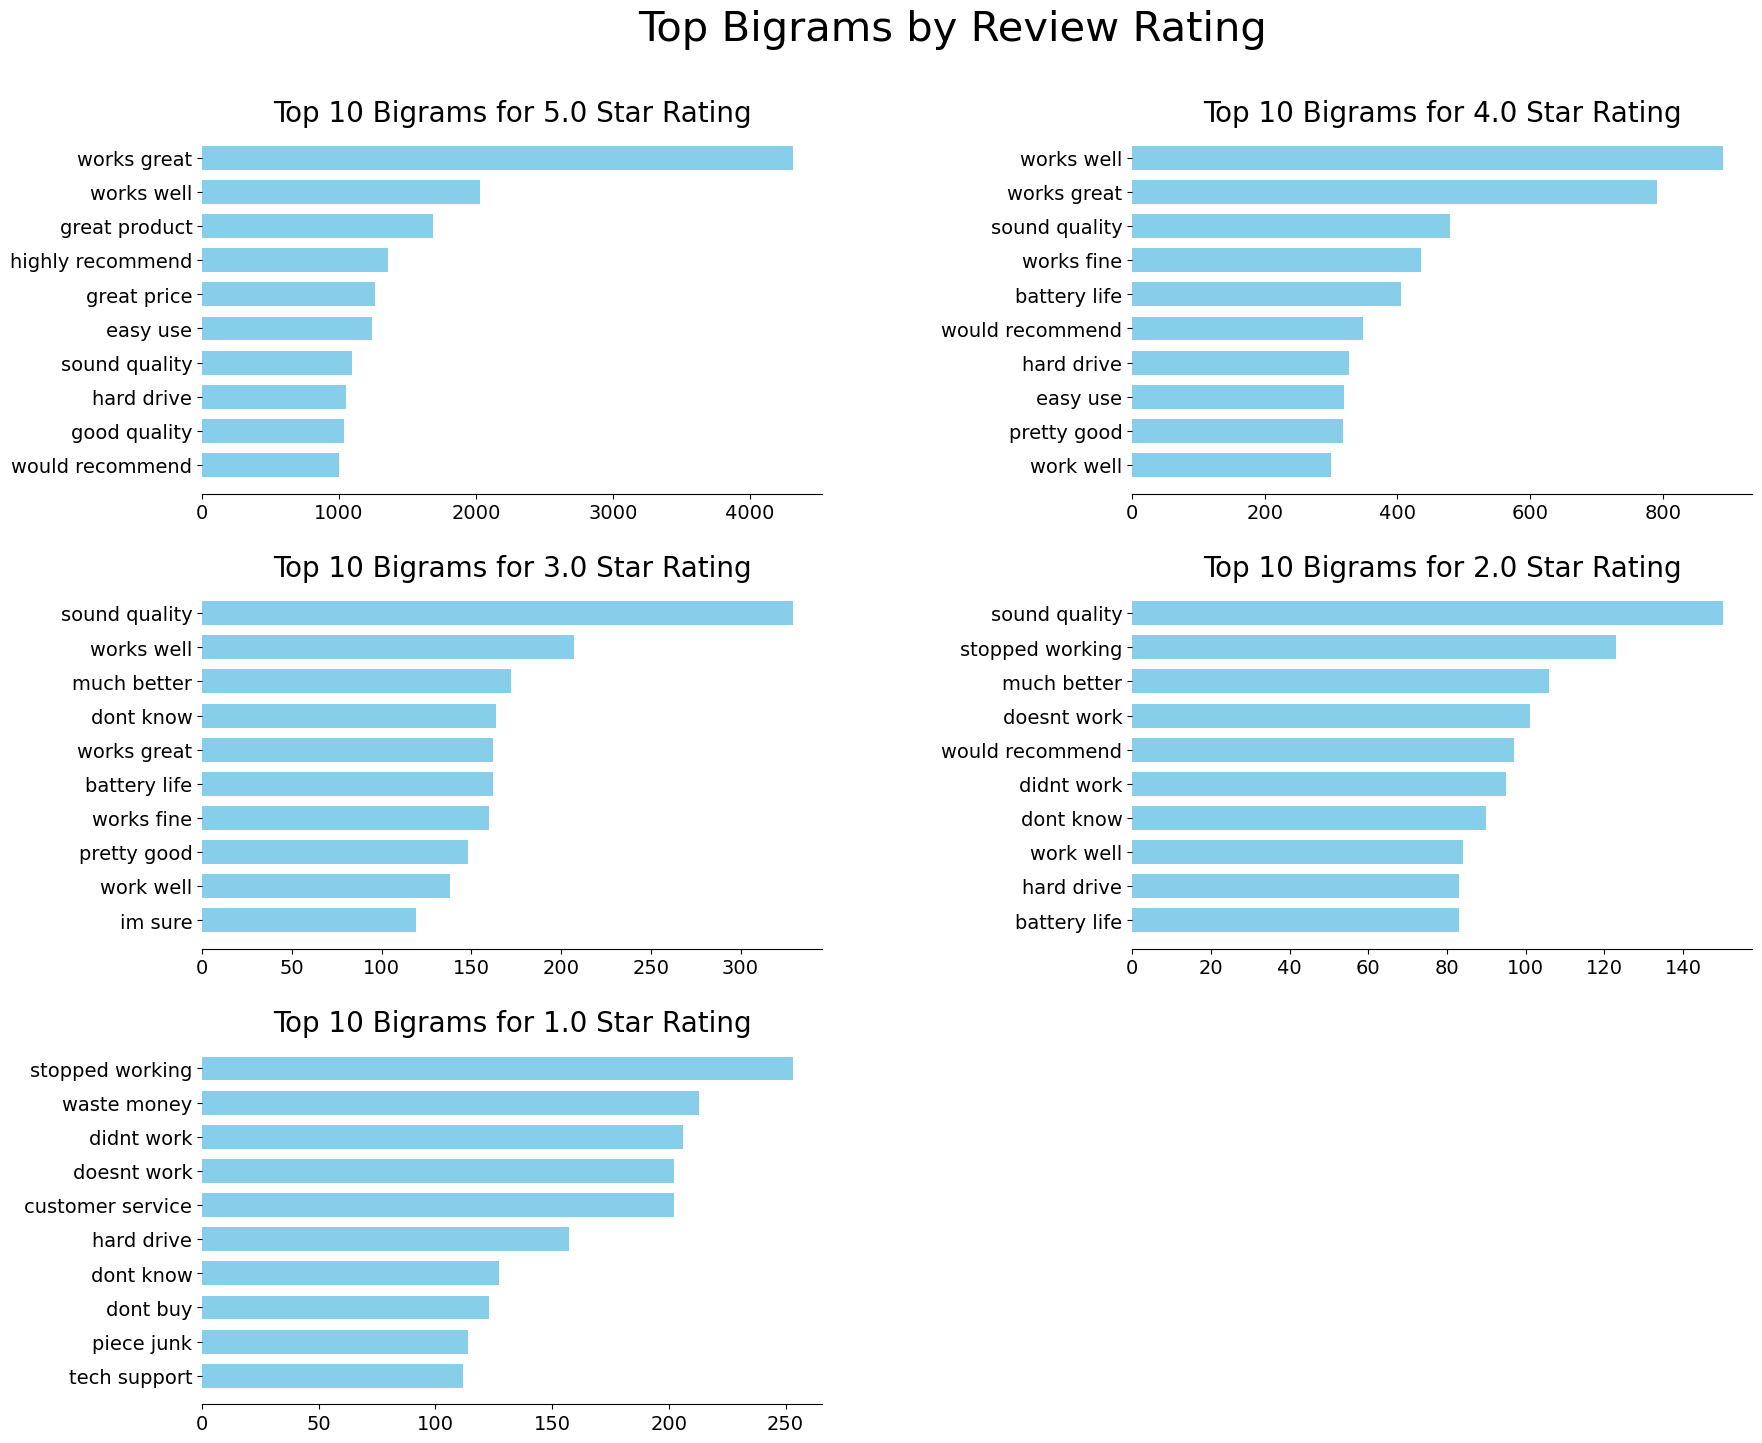

In [11]:
def plot_top_bigrams_by_rating(reviews, n_top_bigrams=10):
    """
    Plots the top `n_top_bigrams` bigrams based on user review rating.
    """
    # Initialize the CountVectorizer for bigrams
    vectorizer = CountVectorizer(max_features=n_top_bigrams, ngram_range=(2, 2))

    # Getting unique values for user review ratings 
    ratings = sorted(reviews['reviewRating'].unique(), reverse=True)
    
    ######### See [4] in references
    # Determine grid size (2x2, 3x3, etc.)
    n_rows = int(np.ceil(len(ratings) / 2))  # 2 columns per row
    n_cols = 2
    ########

    # Initialize figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten() 

    # Loop through review ratings
    for idx, rating in enumerate(ratings):
        # Only look at reviews that have the current rating we are looping for
        filtered_reviews = reviews[reviews['reviewRating'] == rating]['reviewTextClean']

        # Fitting and transforming the reviews (for bigrams in this case)
        X = vectorizer.fit_transform(filtered_reviews)
        terms = vectorizer.get_feature_names_out()  # Extracting bigrams
        frequencies = X.sum(axis=0).A1  # Here, we are taking out the column sums (bigram totals) across all of the data

        # Sorting terms by frequency
        top_features_ind = frequencies.argsort()[-n_top_bigrams:]
        top_features = terms[top_features_ind] 
        weights = frequencies[top_features_ind] 

        # Plot the top n bigrams
        ax = axes[idx]
        ax.barh(top_features, weights, height=0.7, color="skyblue")
        ax.set_title(f"Top {n_top_bigrams} Bigrams for {rating} Star Rating", fontdict={"fontsize": 20})
        ax.tick_params(axis="both", which="major", labelsize=14)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)

    ######### See [5] in references
    # Hide any unused subplots
    for i in range(len(ratings), len(axes)):
        fig.delaxes(axes[i])
    ##########

    fig.suptitle("Top Bigrams by Review Rating", fontsize=30)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.5, hspace=0.25)
    plt.show()


plot_top_bigrams_by_rating(reviews, n_top_bigrams=10)

Much better! These plots provide much better context as to where certain words appear in different review scores, with bigrams like "works great" and "highly recommend" appearing frequently in highly rated products, and bigrams like "stopped working" and "waste money" appearing in lower rated reviews. However, there are still some minor issues with context - like in the case of the two-star reviews where we see a high frequency of reviews saying "would recommend". Outside of this, it looks like we are on the right track. This particular step provides some valuable insight into our feature selection process. Specifically, when moving onto the modeling stage, I will likely elect to use bigrams over unigrams as a feature in prediction. 

## Sentiment Analysis (Polarity and Subjectivity)

In this section, I import the [`textblob`](https://textblob.readthedocs.io/en/dev/) library to assist in calculating the polarity and subjectivity of our cleaned review text data. In case you are not familiar, "polarity" is a continous value that falls in the range [-1, 1], where values closer to -1 indicate more of a negative tone, while values closer to 1 indicate a more positive tone[@PolarityAndSentiment]. "Subjectivity" is also a continuous value, but it falls in the range [0, 1] and quantifies the emotion or level of opinion in a piece of text. Text data with high levels of subjectivity is characterized as having greater opinionation than factual information[@PolarityAndSentiment]. For the analysis here, I will construct a few visualizations to see how these two factors behave in my review data.  

In [12]:
from textblob import TextBlob

In [13]:
# Adding polarity column to data
reviews['Polarity'] = reviews['reviewTextClean'].apply(lambda x: TextBlob(x).polarity)
reviews['Subjectivity'] = reviews['reviewTextClean'].apply(lambda x: TextBlob(x).subjectivity)

- Here are the reviews with the highest and lowest polarity and subjectivity values

In [14]:
#highest and lowest polarity reviews
top_polarity_review = reviews.nlargest(1, 'Polarity')['reviewText'].values[0]
bottom_polarity_review = reviews.nsmallest(1, 'Polarity')['reviewText'].values[0]
# Highest and lowest subjectivity reviews
top_subj_review = reviews.nlargest(1, 'Subjectivity')['reviewText'].values[0]
bottom_subj_review = reviews.nsmallest(1, 'Subjectivity')['reviewText'].values[0]

# Print the full reviews
print("POLARITY")
print("=================")
print(f"HIGHEST: {top_polarity_review}")
print(f"LOWEST: {bottom_polarity_review} \n")
print("SUBJECTIVITY")
print("=================")
print(f"HIGHEST: {top_subj_review}")
print(f"LOWEST: {bottom_subj_review} \n")


POLARITY
HIGHEST: Perfect on samsung s4 mini
LOWEST: I would never recommend this or purchase it again. The fabric is awful material. I dislike the feel of it. I literaly take it off every time I use the product. 

SUBJECTIVITY
HIGHEST: Perfect on samsung s4 mini
LOWEST: Work well! 



### Distributions of Polarity and Subjectivity

Below, I construct two histograms showing the distribution of polarity and subjectivity across our data set

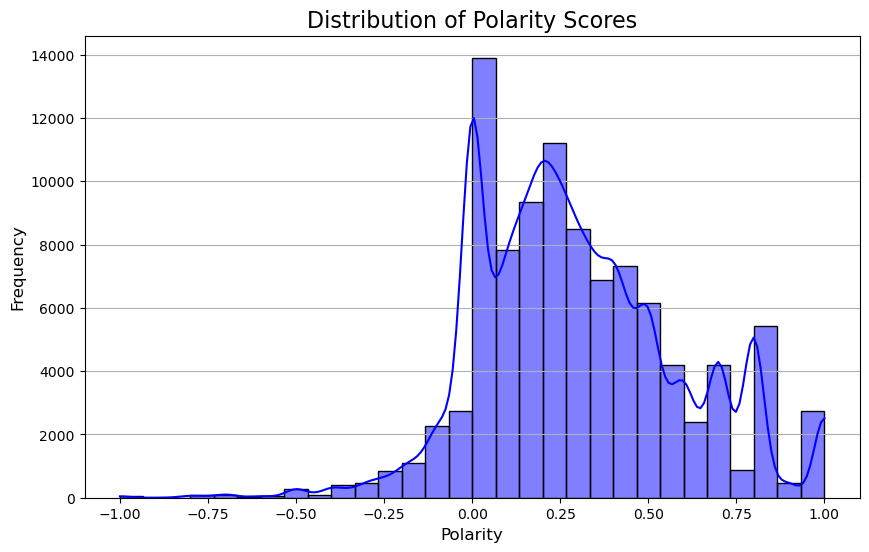

In [15]:
# Plotting polarity Distribution 
plt.figure(figsize=(10,6))
sns.histplot(reviews['Polarity'], kde=True, bins=30, color='blue')
plt.title('Distribution of Polarity Scores', fontsize=16)
plt.xlabel('Polarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y')
plt.show()

When looking at the above plot, it's clear that most of the reviews carry a positive sentiment on average. While there is a large collection of reviews that have a neutral tone, the overall distribution of sentiments leans more to the positive side. We can also see a disproportionately high number of reviews with positive to very positive sentiment on the right tail of the distribution. On the other hand, there are far fewer reviews that carry a negative sentiment, which again shares parallels to Magdelano's bakery review dataset[@Magdelano2024].

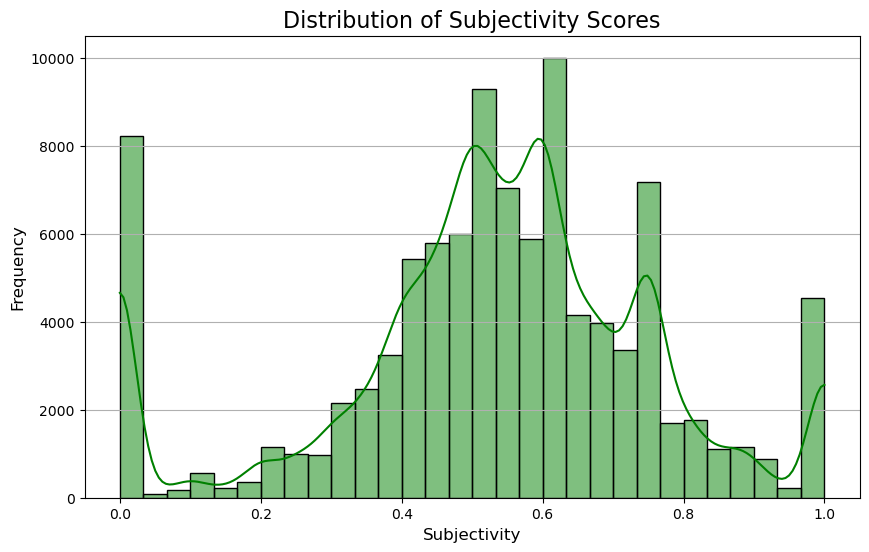

In [16]:
# Plotting Subjectivity Distribution
plt.figure(figsize=(10, 6))
sns.histplot(reviews['Subjectivity'], kde=True, bins=30, color='green')
plt.title('Distribution of Subjectivity Scores', fontsize=16)
plt.xlabel('Subjectivity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y')
plt.show()

Looking now at the distribution of subjectivity across electronics reviews, we see an interesting characteristic. While most reviews possess moderate subjectivity, there are extrememly high occurences of reviews with extremely high and extremely low subjectivity levels. In the case of extreme highs, it's possible that these reviews are on average negative - written by disgruntled customers who went online to vent about their poor experience with the product. On the opposite end, reviews with extremely low subjectivity are likely more thought out and methodical, where the reviewer offers a useful documentation of their experience with the product.

### Scatterplot of Polarity v Subjectivity

To test whether my conjecture about high subjectivity relates to negative polarity or sentiment, I construct a scatterplot between the two below. In the scatterplot, I also fill in points by their corresponding binary class label that I created in the data cleaning section. As a refresher, the `binary_target` variable uses the following condition:

- "positive" for `reviewRating` $\geq 4$
- "negative" for `reviewRating` $< 4$

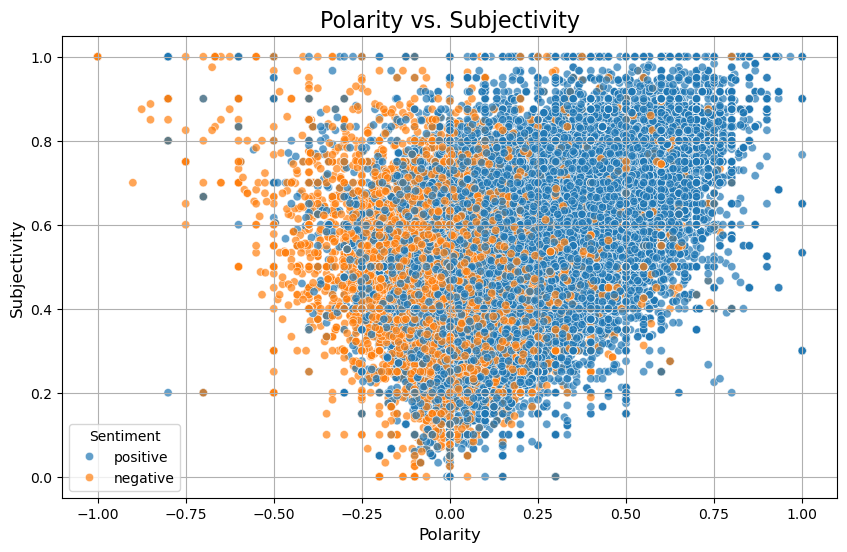

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=reviews, x='Polarity', y='Subjectivity', hue='binary_target', alpha=0.7)
plt.title('Polarity vs. Subjectivity', fontsize=16)
plt.xlabel('Polarity', fontsize=12)
plt.ylabel('Subjectivity', fontsize=12)
plt.legend(title='Sentiment', loc='best')
plt.grid(True)
plt.show()

Contrary to my belief above, subjectivity is not higher for more negative reviews. Instead, this plot demonstrates that subjectivity in fact tends to increase with more extreme values of polarity (regardless of which direction). In other words, reviews that are exceedingly negative ***and*** positive tend to have higher subjectivity values. As for polarity, the relationship is clear: lower polarity tends to relate to reviews classified as "negative", and higher polarity relates to revies classified as "positive".

In [18]:
#| echo: false
reviews.to_csv('../../data/processed-data-large/reviews_short.csv.gz', index=False, compression='gzip')

# Summary 

In this section, perform exploratory data analysis (EDA) on 100,000 samples drawn from a large dataset containing details on Amazon electronics reviews. In the analysis, I looked at the characteristics of the quantitative variables in the dataset (`reviewRating` and `vote`) - Where `reviewRating` corresponds to the rating (1-5) assigned by a user to a product in a single review, and `vote` represents the amount of community votes given to a review. In both cases, I discovered heavy skewness and tailedness in their distributions, with the sample of reviews with non-zero votes having extremely high skewness (58.07) and kurtosis (4208.54).

In the next section of this page, I look at the prevalence of different terms across all five review ratings. When looking only at single term frequency, I struggled to gather any useful context. To reconcile with this, I instead chose to look at frequency of word-pairs across all review ratings, which proved far more useful in understanding the linguistic patterns across the review classes. 

Finally, I took advantage of the `textblob` library to find the polarity and subjectivity of each review. In this section, I discovered that reviews in this dataset are typically possess higher polarity values (more positive). I then shifted my focus toward the subjectivity of the reviews, where I uncovered an interesting phenomenon where there was a disproportionately high frequency of reviews with high and low subjectivity values. With only that in mind, I conjectured that higher subjectivity may coincide with low polarity (i.e. a reviewer's emotions may run high when writing a negative review). However, after creating a scatterplot that compared the two variables, I found this to be untrue. Instead, subjectivity tends to increase with more extreme values of polarity, regardless of direction. 



## Modeling Implications

**Potential use of TF-IDF for single term feature**

While my approach to single-term modeling using a simple bag-of-words `CountVectorizer` approach did not prove helpful, I still want to include single terms as a feature in my modeling process. Therefore, in the modeling section, I will elect to model single terms using a TF-IDF `TfidfVectorizer` instead. The main reason for adopting tf-idf for single terms lies in its consideration of word-weights, which helps to penalize words that appear across all documents and place more emphasis on rarer, more semantically meaningful terms.

**Binary and Multiclass Classification**

In the final scatterplot on this page, I compare subjectivity to polarity, while filling in points according to their binary_target class label (positive or negative). In this plot, you can see a rough separation of "positive" and "negative" reviews across the polarity axis. This discovery shows that polarity score could prove to be useful feature in predicting the binary class of each review later on in the supervised learning section. On the other hand, it is difficult to say whether polarity will be useful when running a multiclass prediction on `reviewRating`

**Regression**

I intend to use the values provided by `textblob`'s polarity function as a dependent variable in a regression model with the goal of predicting polarity for a subset of my data.



## Challenges

[**Data Imbalances**]{style="text-decoration: underline;"}

As I outlined before, there are serious imbalances within the frequencies of different review ratings. In order to account for this, I will try to improve upon the undersampling method used in Magdelano et al[@Magdelano2024].

[**Noisy Data**]{style="text-decoration: underline;"}

It is highly likely (even after processing) that my `reviewTextClean` column may typos, informal language, or otherwise irrelevant content that may impede model performance down the line.



##
**Next Section: [Unsupervised Learning](../unsupervised-learning/main.ipynb)**